In [1]:
from kaggle_secrets import UserSecretsClient
import os

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("stepanibatulov")



   # Create the kaggle.json file
if secret_value_0:
   os.makedirs("/root/.kaggle", exist_ok=True)
   with open("/root/.kaggle/kaggle.json", "w") as f:
       f.write(f'{{"username":"stepanibatulov","key":"{secret_value_0}"}}')
   os.chmod("/root/.kaggle/kaggle.json", 600)  
   print("Kaggle API key set successfully!")
else:
   print("One or both of the Kaggle API key and username are not set as secrets.")

Kaggle API key set successfully!


In [2]:
! mkdir -p /kaggle/working/models/testrun

In [3]:
! kaggle competitions download -c morse-decoder

100%|█████████████████████████████████████▊| 1.25G/1.25G [00:34<00:00, 38.2MB/s]
100%|██████████████████████████████████████| 1.25G/1.25G [00:34<00:00, 38.8MB/s]


In [4]:
! unzip /kaggle/working/morse-decoder.zip -d /kaggle/working/dataset > /dev/null 

In [5]:
! rm -rf /kaggle/working/morse-decoder.zip 

# Ознакомление с данными

In [6]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.0 MB/s eta 0:00:00


In [7]:
import os
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
# import noisereduce as nr
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import scipy
import IPython.display as ipd
import os
import Levenshtein as lv

In [8]:
class Config:
    sr=8000
    n_fft=256
    hop_len=64
    n_mels=64,
    denoise=False
    validate=True
    train_path='/kaggle/working/dataset/train.csv'
    test_path='/kaggle/working/dataset/test.csv'
    audio_path="/kaggle/working/dataset/morse_dataset/morse_dataset"
    

# Анализ 

In [9]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(pd.read_csv(Config.train_path), test_size=0.1, random_state=42)

from collections import defaultdict, Counter

def get_vocab(path):
    data = pd.read_csv(path, usecols=['message']).values
    c = Counter()
    # lens = []
    for i in range(len(data)):
        message = data[i][0]
        # print(message)
        # lens.append(len(message))
        c.update(message)
    chars = sorted(c.keys())
    # print(len(chars))
    char2ind = dict()
    ind2char = dict()
    char2ind['/'] = 44
    ind2char[44] = '/'

    for k, char in enumerate(chars):
        char2ind[char] = k
    ind2char = {k: char for char, k in char2ind.items()}

    return ind2char, char2ind, dict(c)

ind2char, char2ind, char_counts = get_vocab(Config.train_path)

In [10]:
ind2char

{44: '/',
 0: ' ',
 1: '#',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9',
 12: 'А',
 13: 'Б',
 14: 'В',
 15: 'Г',
 16: 'Д',
 17: 'Е',
 18: 'Ж',
 19: 'З',
 20: 'И',
 21: 'Й',
 22: 'К',
 23: 'Л',
 24: 'М',
 25: 'Н',
 26: 'О',
 27: 'П',
 28: 'Р',
 29: 'С',
 30: 'Т',
 31: 'У',
 32: 'Ф',
 33: 'Х',
 34: 'Ц',
 35: 'Ч',
 36: 'Ш',
 37: 'Щ',
 38: 'Ъ',
 39: 'Ы',
 40: 'Ь',
 41: 'Э',
 42: 'Ю',
 43: 'Я'}

<BarContainer object of 44 artists>

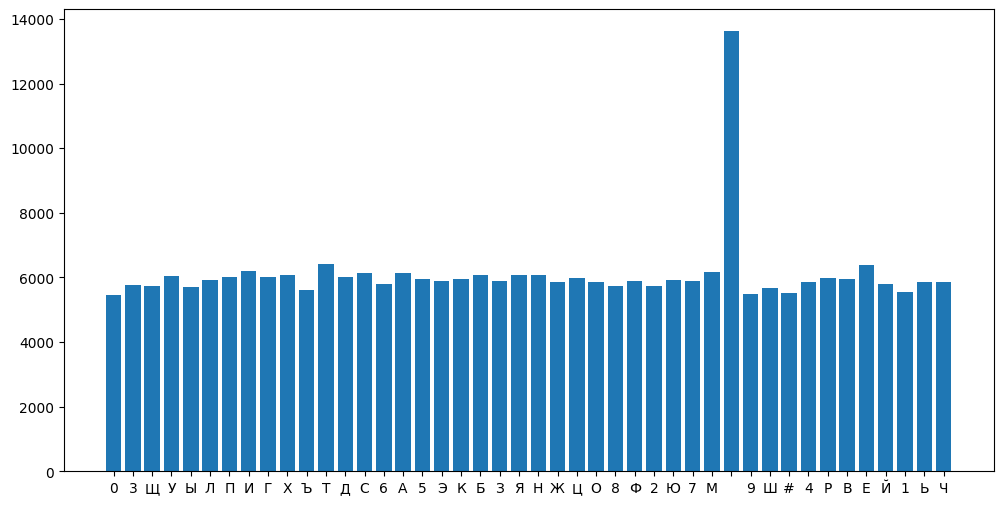

In [11]:
plt.figure(figsize=(12,6))
plt.bar(char_counts.keys(), char_counts.values())

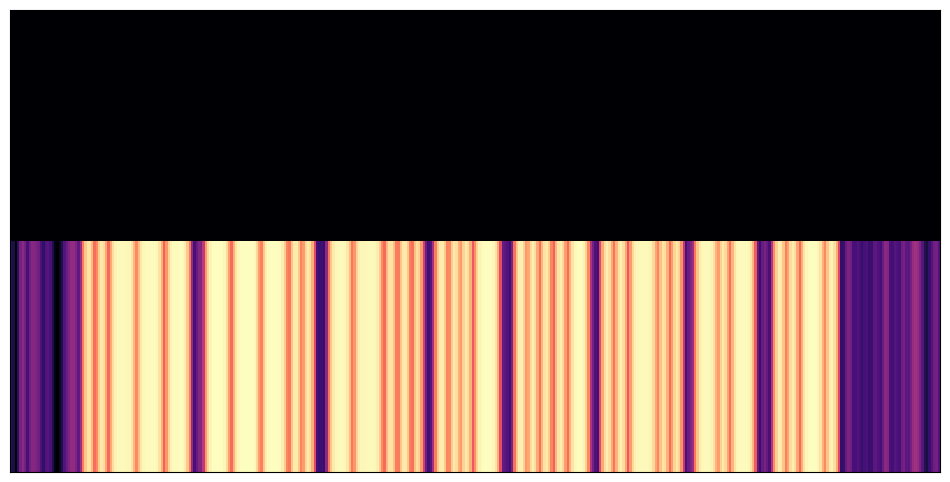

In [12]:
audio = os.path.join(Config.audio_path, '133.opus')
signal, _ = librosa.load(audio, sr=Config.sr)
mel = librosa.feature.melspectrogram(y=signal, sr=8000, n_mels=250, hop_length=160, n_fft=1024)
mel = mel ** 2
mel = librosa.power_to_db(mel, ref=np.max)
mel = mel[int(np.argmax(mel)/mel.shape[1]):int(np.argmax(mel)/mel.shape[1])+2]
mel[1] = -80
plt.figure(figsize=(12,6))
librosa.display.specshow(mel)

## Постановка задачи

### Мне предстоит решать seq2seq задачу. Для обучения буду использовать CTCloss. Благодаря элегантной реализации, эта функция потерь работает быстро вне зависимости от размера словаря и количества шагов по времени. 

## Имеются следующие гипотезы:
* можно обучать модель классифицировать на каждом шаге сразу буквы (модель сможет сама выучить коды морзе для каждого символа в словаре)
* можно обучать модель классифицировать точки и тире, и поставить перед CTCLoos морзе-декодер. (более  сложный путь)

максимальная длина последовательности в обучающем наборе 14.

### для обучения модели я буду использовать CTCloss. Она отлично подходит под эту задачу, т.к. она создана для seq2seq задач.

# Загрузчик данных

In [13]:
from torch.utils.data import Dataset, DataLoader


class MorseTransform:
    def __init__(self, sr, n_fft, hop_length, n_mels, f_min=0, f_max=4000):
        self.transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            # f_min=f_min,
            # f_max=f_max
        )
        # self.scale = librosa.power_to_db(mel, ref=np.max)
        self.scale = torchaudio.transforms.AmplitudeToDB(top_db=80)

    def __call__(self, signal):

        # signal = signal.numpy()
        # signal = librosa.feature.melspectrogram(y=signal, sr=8000, n_mels=250, hop_length=160, n_fft=1024)**2

        # signal = torch.tensor(librosa.power_to_db(signal, ref=np.max)).squeeze(0)

        # max_ind = int(torch.argmax(signal)/signal.shape[1])
        # print(signal.shape)
        # signal = signal[max_ind:max_ind+2, :]

        signal = self.transform(signal).squeeze(0)
        signal = signal**2
        signal = self.scale(signal)
        # # # print(signal.shape)
        max_ind = int(torch.argmax(signal)/signal.shape[1])
        # # # print(signal.shape)
        # # # print(max_ind)
        signal = signal[max_ind:max_ind+1, :]
        
        # # print(mel.shape)

        
        # signal[1, :] = -80
        min_val = torch.min(signal)
        max_val = torch.max(signal)
        
        if max_val == min_val:
            return torch.zeros_like(signal)  # если сигнал плоский — просто нули
    
        signal = 2 * (signal - min_val) / (max_val - min_val) - 1
        return signal # shape (1, 1, 401)


class MorseDataset(Dataset):
    def __init__(self, audio_files, transform, char2ind, targets=None):
        self.audio_files = audio_files
        self.targets = targets
        self.transform = transform
        self.char2ind = char2ind

    def __len__(self):
        return len(self.audio_files)
        
    def __getitem__(self, ind):
        audio_file = self.audio_files[ind]
        signal, org_sr = torchaudio.load(os.path.join(Config.audio_path, audio_file))
        signal = torchaudio.functional.resample(signal, orig_freq=org_sr, new_freq=Config.sr)  
        # min_val = torch.min(signal)
        # max_val = torch.max(signal)
        
        # if max_val == min_val:
        #     return torch.zeros_like(signal)  # если сигнал плоский, заполняет нулями
    
        # signal = 2 * (signal - min_val) / (max_val - min_val) - 1

        
        mel = self.transform(signal)

        if self.targets is not None:
            return mel, torch.tensor([self.char2ind[char] for char in self.targets[ind]], dtype=torch.long)
        
        return mel
    

def collate_fn(batch):
    return list(zip(*batch))

transform = MorseTransform(
    sr=Config.sr,
    n_fft=1024,
    hop_length=160,
    n_mels=250,
    # f_min=200,
    # f_max=2000
)

train_dataset = MorseDataset(
    audio_files=pd.read_csv(Config.train_path).id.values,
    targets=pd.read_csv(Config.train_path).message.values,
    transform=transform,
    char2ind=char2ind
)
val_dataset = MorseDataset(
    audio_files=val_data.id.values,
    targets=val_data.message.values,
    transform=transform,
    char2ind=char2ind
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, collate_fn=collate_fn, shuffle=True)


# Модель

### Я буду обучать модель с архитектурой CRNN. Это хорошая архитектура для задачи seq2seq

In [14]:


class MorseDecoder(nn.Module):
    def __init__(self, num_classes=45):
        super(MorseDecoder, self).__init__()
        
        # блок свертки
        self.cnn = nn.Sequential(
            nn.Conv1d(1,32,kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
            nn.ReLU(),

            nn.Conv1d(32,64,kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            nn.ReLU(),
        )
        # блок rnn
        self.gru = nn.GRU(
            input_size=64,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        self.classifier = nn.Linear(256,45)
        
    def forward(self, x):
        # input (batch, c, time)
        x = self.cnn(x)
        x = x.permute(0, 2, 1) # (batch, time, c)

        x, _ = self.gru(x)

        x = self.classifier(x)
        x = x.permute(1, 0, 2) # (time, batch, c)
        
        return x.log_softmax(dim=-1)

# Example usage
if __name__ == "__main__":

    time_steps = 401
    batch_size = 16
    num_classes = 45  
    
    model = MorseDecoder(num_classes)
    
    dummy_input = torch.randn(batch_size, 1, time_steps)

    output = model(dummy_input)
    print(f"Output shape: {output.shape}") 

Output shape: torch.Size([100, 16, 45])


In [15]:
from torchinfo import summary
model = MorseDecoder(45)
summary(model, input_size=(2,1, 401))

Layer (type:depth-idx)                   Output Shape              Param #
MorseDecoder                             [100, 2, 45]              --
├─Sequential: 1-1                        [2, 64, 100]              --
│    └─Conv1d: 2-1                       [2, 32, 401]              192
│    └─BatchNorm1d: 2-2                  [2, 32, 401]              64
│    └─MaxPool1d: 2-3                    [2, 32, 200]              --
│    └─ReLU: 2-4                         [2, 32, 200]              --
│    └─Conv1d: 2-5                       [2, 64, 200]              6,208
│    └─BatchNorm1d: 2-6                  [2, 64, 200]              128
│    └─MaxPool1d: 2-7                    [2, 64, 100]              --
│    └─ReLU: 2-8                         [2, 64, 100]              --
├─GRU: 1-2                               [2, 100, 256]             445,440
├─Linear: 1-3                            [2, 100, 45]              11,565
Total params: 463,597
Trainable params: 463,597
Non-trainable params: 0

In [16]:
from tqdm.notebook import tqdm
from collections import defaultdict
import torch
import torch.nn as nn

class Engine:
    def __init__(self, model, n_epochs, criterion, optim, device, ind2char, scheduler=None, early_stop=None):
        self.model = model
        self.n_epochs = n_epochs
        self.criterion = criterion
        self.optim = optim
        self.scheduler = scheduler
        self.device = device
        self.early_stop = early_stop
        self.ind2char = ind2char
        

    # def get_warmup_lr(self, epoch, warmup_epochs=10):
    #     if epoch < warmup_epochs:
    #         return self.get_current_lr() * (epoch + 1) / warmup_epochs
    #     return self.get_current_lr()
    
    # def get_current_blank_penalty(self, epoch):
    #     """Calculate current blank penalty based on epoch"""
    #     if epoch >= self.blank_decay_epochs:
    #         return self.final_blank_penalty
    #     else:
    #         return self.initial_blank_penalty - epoch * self.blank_penalty_decay
    
    # def get_current_lr(self):
    #     """Get current learning rate"""
    #     for param_group in self.optim.param_groups:
    #         return param_group['lr']
    #     return 0

    def fit(self, train_loader, val_loader=None):
        history_loss = defaultdict(list)
        history_metrics = defaultdict(list)
        
        for epoch in range(self.n_epochs):
            # if epoch < 10:  # warmup for 10 epochs
            #     for param_group in self.optim.param_groups:
            #         param_group['lr'] = self.get_warmup_lr(epoch)
            # current_lr = self.get_current_lr()
            # current_penalty = self.get_current_blank_penalty(epoch)
            
            print(f"EPOCH {epoch}/{self.n_epochs} starting...")
            
            self.model.train()
            train_loss = 0
            train_distance = 0
            tk = tqdm(train_loader, total=len(train_loader))
            
            for inputs, targets in tk:
                # print(inputs.shape)

                self.optim.zero_grad()
                # print(inputs.shape)
                inputs = torch.stack(inputs).to(self.device)
                preds = self.model(inputs)
                input_lengths = torch.full(size=(preds.shape[1],), fill_value=preds.shape[0], dtype=torch.long, device=self.device)
                target_lengths = torch.tensor([len(t) for t in targets], dtype=torch.long)
                target_lengths = target_lengths.to(self.device)
                targets = torch.cat(targets).to(self.device)

                # print(preds.shape)
                # break
            # break
                # # Use dynamic blank penalty
                # blank_penalty = current_penalty * torch.mean(torch.sigmoid(preds[:, :, 0]))
                
                loss = self.criterion(preds, targets, input_lengths, target_lengths) #+ blank_penalty

                loss.backward()
                # nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optim.step()

                train_loss += loss.item()

                decoded_preds, decoded_y = self._decode_preds(preds.cpu()), self._decode_targets(targets.cpu(), target_lengths.cpu())
                distance = self._compute_batch_distance(decoded_preds, decoded_y)

                train_distance += distance
                tk.set_postfix({'epoch': epoch, 'loss': loss.item()})
                
            train_distance /= len(train_loader)
            train_loss /= len(train_loader)
            history_loss['train'].append(train_loss)
            history_metrics['train'].append(train_distance)
            print(f"EPOCH {epoch} train loss {train_loss}")
            print(f"EPOCH {epoch} train distance {train_distance}")
            # history_metrics['blank_penalty'].append(current_penalty)
            # history_metrics['learning_rate'].append(current_lr)

            if val_loader:
                print("Processing validation...")
                self.model.eval()
                outputs = defaultdict(list)
                eval_loss = 0
                eval_distance = 0
                
                with torch.no_grad():
                    tk = tqdm(val_loader, total=len(val_loader))
                    
                    for i, batch in enumerate(tk):
                        inputs, targets = batch
                        # print(inputs.shape)
                        inputs = torch.stack(inputs).to(self.device)
                        preds = self.model(inputs)
                        input_lengths = torch.full(size=(preds.shape[1],), fill_value=preds.shape[0], dtype=torch.long, device=self.device)
                        target_lengths = torch.tensor([len(t) for t in targets], dtype=torch.long)
                        target_lengths = target_lengths.to(self.device)
                        targets = torch.cat(targets).to(self.device)

                        # # Use same dynamic penalty for validation
                        # blank_penalty = current_penalty * torch.mean(torch.sigmoid(preds[:, :, 0]))
                        
                        loss = self.criterion(preds, targets, input_lengths, target_lengths) #+ blank_penalty
                        eval_loss += loss.item()
                        # if (i+1) % 3 == 0:
                        #     print(self._decode_preds(preds))

                        decoded_preds, decoded_y = self._decode_preds(preds.cpu()), self._decode_targets(targets.cpu(), target_lengths.cpu())
                        distance = self._compute_batch_distance(decoded_preds, decoded_y)
                        # print(f"LEVENSHTEIN: {distance}")
                        eval_distance += distance
                        # break
                        outputs['pred'].append(preds)
                        outputs['target'].append(targets)
                        tk.set_postfix({'epoch': epoch, 'loss': loss.item()})

                    eval_loss /= len(val_loader)
                    eval_distance /= len(val_loader)
                    history_loss['val'].append(eval_loss)
                    history_metrics['val'].append(eval_distance)
                    print(f"EPOCH {epoch} val loss {eval_loss}")
                    print(f"EPOCH {epoch} val distance {eval_distance}")
                    
                    # # Step the scheduler
                    # if self.scheduler:
                    #     self.scheduler.step(eval_loss)
                    
                    # # Check early stopping
                    # if self.early_stop and self.early_stop.should_stop(eval_loss):
                    #     print("Early stopping!")
                    #     break
                torch.save(self.model.state_dict(), f"/kaggle/working/models/testrun/model_epoch{epoch}.pth")
                print("MODEL SAVED")

        if val_loader:
            return history_loss, history_metrics, outputs
        else:
            return history_loss, history_metrics

    def _compute_batch_distance(self, preds, targets):
        distance = 0
        for entry in zip(preds, targets):
            distance += lv.distance(entry[0], entry[1])
        distance /= len(preds)
        return distance
            

    def _decode_preds(self, pred):
        pred = pred.permute(1, 0, 2)  # B, T, C
        pred_inds = pred.argmax(dim=-1)  # B, T
        texts = []
        for batch in pred_inds:
            text = []
            prev = -1
            for char_ind in batch:
                if char_ind != prev and char_ind != 0:
                    text.append(self.ind2char[char_ind.item()])
                prev = char_ind
            texts.append("".join(text))
        return texts

    def _decode_targets(self, labels, lengths):
        texts = []
        start_ind = 0
        for i in range(len(lengths)):
            length = lengths[i]
            label = labels[start_ind:start_ind+length].cpu().numpy()
            texts.append("".join([self.ind2char[ind] for ind in label]))
            start_ind += length
        return texts

    def predict_one_sample(self, input_path):
        signal, org_sr = torchaudio.load(os.path.join(AUDIO_PATH, input_path))
        signal = torchaudio.functional.resample(signal, orig_freq=org_sr, new_freq=Config.sr)
        mel = transform(signal)
        prediction = self.model(mel)
        return prediction
    
    def submit(self, loader):
        pass


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MorseDecoder(45).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # Learning rate scheduler with warm-up and cosine annealing
# def lr_lambda(epoch):
#     warmup_epochs = 5
#     if epoch < warmup_epochs:
#         return (epoch + 1) / warmup_epochs  # Linear warm-up from 0.2 to 1.0
#     else:
#         # Cosine annealing after warm-up
#         decay_epochs = 30 - warmup_epochs
#         decay_progress = (epoch - warmup_epochs) / decay_epochs
#         return 0.5 * (1 + torch.cos(torch.tensor(decay_progress * 3.14159)))

# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Alternative: Use cosine annealing with warm restarts to help escape local minima
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
scheduler = None

engine = Engine(
    model=model,
    n_epochs=10,
    criterion=nn.CTCLoss(blank=44, zero_infinity=True),
    optim=optimizer,
    scheduler=scheduler,
    device=device,
    ind2char=ind2char,
)

dev_data = pd.read_csv('/kaggle/working/dataset/train.csv').iloc[:500]
one, two = train_test_split(dev_data, test_size=0.2, random_state=42)
dev_dataset = MorseDataset(
    audio_files=one.id.values,
    targets=one.message.values,
    transform=transform,
    char2ind=char2ind
)
dev_val_set = MorseDataset(
    audio_files=two.id.values,
    targets=two.message.values,
    transform=transform,
    char2ind=char2ind
)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=4)
dev_val_loader = DataLoader(dev_val_set, batch_size=64, collate_fn=collate_fn, num_workers=4)

history_loss, history_metrics, outputs = engine.fit(train_loader,val_loader)

EPOCH 0/10 starting...


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH 0 train loss 4.281565094299154
EPOCH 0 train distance 8.928893479033405
Processing validation...


  0%|          | 0/47 [00:00<?, ?it/s]

EPOCH 0 val loss 3.997015379844828
EPOCH 0 val distance 8.911521656534953
MODEL SAVED
EPOCH 1/10 starting...


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH 1 train loss 1.9299600382031663
EPOCH 1 train distance 9.410370024875622
Processing validation...


  0%|          | 0/47 [00:00<?, ?it/s]

EPOCH 1 val loss 0.30067865962677814
EPOCH 1 val distance 9.84579217325228
MODEL SAVED
EPOCH 2/10 starting...


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH 2 train loss 0.23696191373791523
EPOCH 2 train distance 9.778751332622601
Processing validation...


  0%|          | 0/47 [00:00<?, ?it/s]

EPOCH 2 val loss 0.19321562365648595
EPOCH 2 val distance 9.694908814589665
MODEL SAVED
EPOCH 3/10 starting...


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH 3 train loss 0.17788019843065916
EPOCH 3 train distance 9.727989516702202
Processing validation...


  0%|          | 0/47 [00:00<?, ?it/s]

EPOCH 3 val loss 0.1518765164816633
EPOCH 3 val distance 9.702365121580547
MODEL SAVED
EPOCH 4/10 starting...


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH 4 train loss 0.15107693458035557
EPOCH 4 train distance 9.710654317697228
Processing validation...


  0%|          | 0/47 [00:00<?, ?it/s]

EPOCH 4 val loss 0.13988898155537058
EPOCH 4 val distance 9.741451367781155
MODEL SAVED
EPOCH 5/10 starting...


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH 5 train loss 0.13147330167355822
EPOCH 5 train distance 9.693874378109452
Processing validation...


  0%|          | 0/47 [00:00<?, ?it/s]

EPOCH 5 val loss 0.11769683730412037
EPOCH 5 val distance 9.700607902735563
MODEL SAVED
EPOCH 6/10 starting...


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH 6 train loss 0.11955865919748858
EPOCH 6 train distance 9.690242981520965
Processing validation...


  0%|          | 0/47 [00:00<?, ?it/s]

EPOCH 6 val loss 0.11409263772533294
EPOCH 6 val distance 9.667078267477203
MODEL SAVED
EPOCH 7/10 starting...


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH 7 train loss 0.10963894883150867
EPOCH 7 train distance 9.687855366027009
Processing validation...


  0%|          | 0/47 [00:00<?, ?it/s]

EPOCH 7 val loss 0.09501710989849364
EPOCH 7 val distance 9.644424392097266
MODEL SAVED
EPOCH 8/10 starting...


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH 8 train loss 0.10209704451024659
EPOCH 8 train distance 9.682880241648897
Processing validation...


  0%|          | 0/47 [00:00<?, ?it/s]

EPOCH 8 val loss 0.08805313294238233
EPOCH 8 val distance 9.641859802431611
MODEL SAVED
EPOCH 9/10 starting...


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH 9 train loss 0.09404308855660688
EPOCH 9 train distance 9.682980188343993
Processing validation...


  0%|          | 0/47 [00:00<?, ?it/s]

EPOCH 9 val loss 0.08771593638874114
EPOCH 9 val distance 9.61265197568389
MODEL SAVED


# Кривые обучения

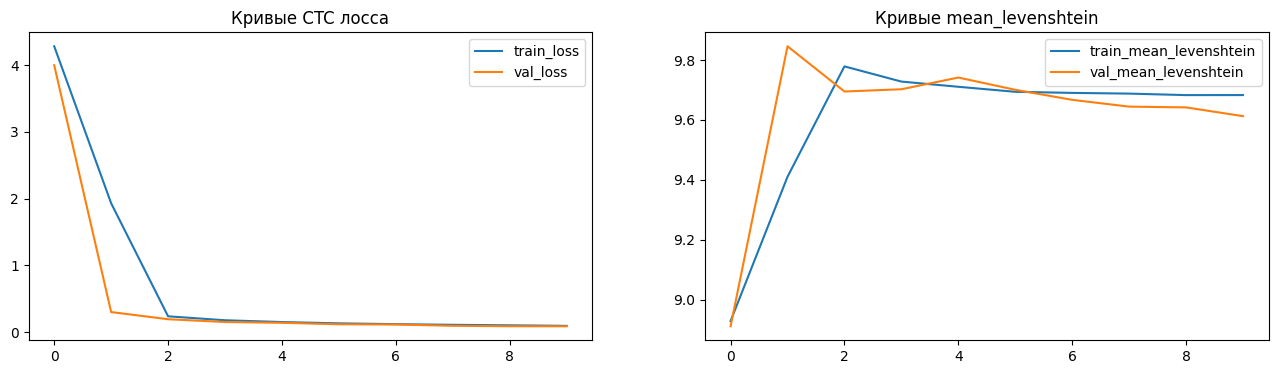

In [17]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

epoch_list = range(engine.n_epochs)

ax[0].plot(epoch_list, history_loss['train'], label="train_loss")
ax[0].plot(epoch_list, history_loss['val'], label="val_loss")
ax[0].set_title("Кривые CTC лосса")
ax[0].legend()

ax[1].plot(epoch_list, history_metrics['train'], label="train_mean_levenshtein")
ax[1].plot(epoch_list, history_metrics['val'], label="val_mean_levenshtein")
ax[1].set_title("Кривые mean_levenshtein")
ax[1].legend()

# Метрика на холд-ауте

In [18]:
def create_submission(test_data, test_set):
    predictions = []
    for i in range(len(test_set)):
        signal = test_set[i]
        if signal.size(1) > 401:
            signal = torch.nn.functional.pad(signal, (0,5), value=-1) # длина 2406, нацело делится на 401
            start_ind=0
            # print(signal.size(1)/401)
            prediction = ""
            for _ in range(int(signal.size(1)/401)):
                signal_part=signal[:, start_ind:start_ind+401].unsqueeze(0).to(engine.device)
                start_ind+=401
                pred = engine.model(signal_part)
                pred = engine._decode_preds(pred)[0]
                prediction += pred
            predictions.append(prediction)

        else:
            pred = engine.model(signal.unsqueeze(0).to(engine.device))
            pred = engine._decode_preds(pred)[0]
            predictions.append(pred)
        
    test_data['message'] = predictions
    return test_data
                
                            
            # print(signal[:, :401].shape)
test_data = pd.read_csv("/kaggle/working/dataset/sample_submission.csv")
test_set = MorseDataset(
    audio_files=test_data.id.values,
    transform=transform,
    char2ind=char2ind
)
test_data = create_submission(test_data, test_set)


In [19]:
test_data[-18:]

,id,message
4982,34983.opus,/5/У/М/0/А/О/Н/Ю/
4983,34984.opus,/Д/А/М/Н/А/М/Т//Д/О/И/Р/С//М/С/А/М/Ц/////
4984,34985.opus,/И/Л/Ь/С/В/Е/Д/Т/К/Ч/В/Н/Т/И//Я/М/Д/М/Ы/М/Ю/Н/...
4985,34986.opus,/А/Н/Х/В/С/О/Е/Г/Ь//Р/В/К//Д/А/М/И/Н/К/Ш/М/Д/Н...
4986,34987.opus,/И/Л/Д/А/С/Д/П/Ь/С/О/Е/М/У/Н/Т/И/И/Г/В/К/С/О/Е...
4987,34988.opus,/Е/Т/Ь/Т/К/П/Д/С/Я/Н/К/М/Ы/Т/Ц/И/М/К/////
4988,34989.opus,/К/Н/О/Ь/К/М/С/О/Н/Ы/М/О//П/Ь/С/Ю/Н/В/М/////
4989,34990.opus,/И/Л/Ь/С/О/Е/Н/Д/М/Ы/М/Й//М/Н/У/С/Й/Ы/М/Ч/А/Т/...
4990,34991.opus,/И/Л/Д/А/С/Д/П/О/С/Ю/В//Ы/М//Н/Ю/Й/Г/Р/Г/Е/Т/Ы...
4991,34992.opus,/А/С/А/Т/И/С/Ч/И/К/Г//Ж/Н/Е/П/О/Ц/Ю/Н//Н/Й/Е/С...


In [20]:
test_data.to_csv("/kaggle/working/submission.csv")